In [1]:
import cartopy

In [2]:
import xarray as xr
import sys
sys.path.insert(0,"/Users/auraoupa/lib/python")

import numpy as np
sys.path.insert(0,"/Users/auraoupa/Work/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import cmocean
import matplotlib.pylab as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

sys.path.insert(0,"/Users/auraoupa/lib/python/w_k_scripts")
import Wavenum_freq_spec_func as wfs

In [3]:
gridfile="/Users/auraoupa/Data/eNATL60/eNATL60-I/mesh_mask_eNATL60_3.6.nc"
dsgrid=xr.open_mfdataset(gridfile)
ff=dsgrid['ff']

In [4]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((-36, -26, 25, 40))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1)
    plt.title(title)

    ax.plot([-31, -28], [33, 33],color='black',linewidth=4)
    ax.plot([-31, -28], [36, 36],color='black',linewidth=4)
    ax.plot([-31, -31], [33, 36],color='black',linewidth=4)
    ax.plot([-28, -28], [33, 36],color='black',linewidth=4)


In [5]:
print np.min(ff[0].values),np.max(ff[0].values)

1.6118568566538608e-05 0.00013463505001099854


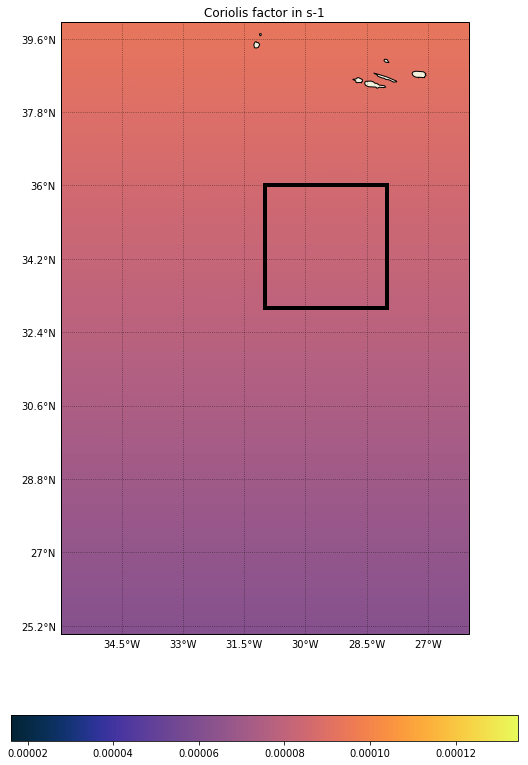

In [6]:
fig=plt.figure(figsize=(20,15))

navlat= dsgrid['nav_lat']
navlon= dsgrid['nav_lon']
plot_surf(121,ff[0],navlon,navlat,np.min(ff[0].values),np.max(ff[0].values),cmocean.cm.thermal,'Coriolis factor in s-1')



In [7]:
## Dataset

dirtide="/Users/auraoupa/Data/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotide="/Users/auraoupa/Data/eNATL60/eNATL60-BLB002-S/1h/ACO/"



In [8]:
filesUtide="eNATL60ACO-BLBT02_1h_*_gridU-2D_*.nc"
filesVtide="eNATL60ACO-BLBT02_1h_*_gridV-2D_*.nc"

tfilesUtide=dirtide+filesUtide
tfilesVtide=dirtide+filesVtide

filesUnotide="eNATL60ACO-BLB002_1h_*_gridU-2D_*.nc"
filesVnotide="eNATL60ACO-BLB002_1h_*_gridV-2D_*.nc"

tfilesUnotide=dirnotide+filesUnotide
tfilesVnotide=dirnotide+filesVnotide


In [9]:
fUtide = xr.open_mfdataset(tfilesUtide)
Utide=fUtide['sozocrtx'][:]
navlat= fUtide['nav_lat']
navlon= fUtide['nav_lon']

fUnotide = xr.open_mfdataset(tfilesUnotide)
Unotide=fUnotide['sozocrtx'][:]

fVtide = xr.open_mfdataset(tfilesVtide)
Vtide=fVtide['somecrty'][:]

fVnotide = xr.open_mfdataset(tfilesVnotide)
Vnotide=fVnotide['somecrty'][:]


In [10]:
T=2*np.pi/(1E-4)

In [11]:
print T

62831.8530718


In [12]:
wutide=Utide.window
wutide.set(n=48,dim='time_counter', cutoff=2*T)
Utidefilt=wutide.convolve()

In [13]:
wunotide=Unotide.window
wunotide.set(n=48,dim='time_counter', cutoff=2*T)
Unotidefilt=wunotide.convolve()

In [14]:
wvtide=Vtide.window
wvtide.set(n=48,dim='time_counter', cutoff=2*T)
Vtidefilt=wvtide.convolve()

In [15]:
wvnotide=Vnotide.window
wvnotide.set(n=48,dim='time_counter', cutoff=2*T)
Vnotidefilt=wvnotide.convolve()

In [16]:
box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

lats=navlat[where]
lons=navlon[where]


In [17]:

ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]


In [18]:
Utidefiltbox=Utidefilt[:,jmin:jmax+1,imin:imax+1]
Vtidefiltbox=Vtidefilt[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Utidefiltbox[0])
Utide_No_NaN = Utidefiltbox.interpolate_na(dim='y')
Utide_dtr = wfs.detrendn(Utide_No_NaN,axes=[0,1,2])
Utide_wdw = wfs.apply_window(Utide_dtr, Utide_dtr.dims, window_type='hanning')
Utidehat = xfft.fft(Utide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Utide_psd = xfft.psd(Utidehat)
Utide_frequency,kx,ky = wfs.get_f_kx_ky(Utidehat)
Utidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Utidefilt_psd_np = Utide_psd.values
Utidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Utidefilt_wavenumber,Utidefilt_psd_np)

dx,dy = wfs.get_dx_dy(Vtidefiltbox[0])
Vtide_No_NaN = Vtidefiltbox.interpolate_na(dim='y')
Vtide_dtr = wfs.detrendn(Vtide_No_NaN,axes=[0,1,2])
Vtide_wdw = wfs.apply_window(Vtide_dtr, Vtide_dtr.dims, window_type='hanning')
Vtidehat = xfft.fft(Vtide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vtide_psd = xfft.psd(Vtidehat)
Vtide_frequency,kx,ky = wfs.get_f_kx_ky(Vtidehat)
Vtidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vtidefilt_psd_np = Vtide_psd.values
Vtidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vtidefilt_wavenumber,Vtidefilt_psd_np)

KEtidefilt_wavenum_freq_spectrum=0.5*(Utidefilt_wavenum_freq_spectrum+Vtidefilt_wavenum_freq_spectrum)


0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700


In [19]:
Unotidefiltbox=Unotidefilt[:,jmin:jmax+1,imin:imax+1]
Vnotidefiltbox=Vnotidefilt[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Unotidefiltbox[0])
Unotide_No_NaN = Unotidefiltbox.interpolate_na(dim='y')
Unotide_dtr = wfs.detrendn(Unotide_No_NaN,axes=[0,1,2])
Unotide_wdw = wfs.apply_window(Unotide_dtr, Unotide_dtr.dims, window_type='hanning')
Unotidehat = xfft.fft(Unotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Unotide_psd = xfft.psd(Unotidehat)
Unotide_frequency,kx,ky = wfs.get_f_kx_ky(Unotidehat)
Unotidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Unotidefilt_psd_np = Unotide_psd.values
Unotidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Unotidefilt_wavenumber,Unotidefilt_psd_np)

dx,dy = wfs.get_dx_dy(Vnotidefiltbox[0])
Vnotide_No_NaN = Vnotidefiltbox.interpolate_na(dim='y')
Vnotide_dtr = wfs.detrendn(Vnotide_No_NaN,axes=[0,1,2])
Vnotide_wdw = wfs.apply_window(Vnotide_dtr, Vnotide_dtr.dims, window_type='hanning')
Vnotidehat = xfft.fft(Vnotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vnotide_psd = xfft.psd(Vnotidehat)
Vnotide_frequency,kx,ky = wfs.get_f_kx_ky(Vnotidehat)
Vnotidefilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vnotidefilt_psd_np = Vnotide_psd.values
Vnotidefilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vnotidefilt_wavenumber,Vnotidefilt_psd_np)

KEnotidefilt_wavenum_freq_spectrum=0.5*(Unotidefilt_wavenum_freq_spectrum+Vnotidefilt_wavenum_freq_spectrum)


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [20]:
Utidebox=Utide[:,jmin:jmax+1,imin:imax+1]
Vtidebox=Vtide[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Utidebox[0])
Utide_No_NaN = Utidebox.interpolate_na(dim='y')
Utide_dtr = wfs.detrendn(Utide_No_NaN,axes=[0,1,2])
Utide_wdw = wfs.apply_window(Utide_dtr, Utide_dtr.dims, window_type='hanning')
Utidehat = xfft.fft(Utide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Utide_psd = xfft.psd(Utidehat)
Utide_frequency,kx,ky = wfs.get_f_kx_ky(Utidehat)
Utide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Utide_psd_np = Utide_psd.values
Utide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Utide_wavenumber,Utide_psd_np)

dx,dy = wfs.get_dx_dy(Vtidebox[0])
Vtide_No_NaN = Vtidebox.interpolate_na(dim='y')
Vtide_dtr = wfs.detrendn(Vtide_No_NaN,axes=[0,1,2])
Vtide_wdw = wfs.apply_window(Vtide_dtr, Vtide_dtr.dims, window_type='hanning')
Vtidehat = xfft.fft(Vtide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vtide_psd = xfft.psd(Vtidehat)
Vtide_frequency,kx,ky = wfs.get_f_kx_ky(Vtidehat)
Vtide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vtide_psd_np = Vtide_psd.values
Vtide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vtide_wavenumber,Vtide_psd_np)

KEtide_wavenum_freq_spectrum=0.5*(Utide_wavenum_freq_spectrum+Vtide_wavenum_freq_spectrum)


0
100
200
300
400
500
600
700
0
100
200
300
400
500
600
700


In [21]:
Unotidebox=Unotide[:,jmin:jmax+1,imin:imax+1]
Vnotidebox=Vnotide[:,jmin:jmax+1,imin:imax+1]

dx,dy = wfs.get_dx_dy(Unotidebox[0])
Unotide_No_NaN = Unotidebox.interpolate_na(dim='y')
Unotide_dtr = wfs.detrendn(Unotide_No_NaN,axes=[0,1,2])
Unotide_wdw = wfs.apply_window(Unotide_dtr, Unotide_dtr.dims, window_type='hanning')
Unotidehat = xfft.fft(Unotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Unotide_psd = xfft.psd(Unotidehat)
Unotide_frequency,kx,ky = wfs.get_f_kx_ky(Unotidehat)
Unotide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Unotide_psd_np = Unotide_psd.values
Unotide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Unotide_wavenumber,Unotide_psd_np)

dx,dy = wfs.get_dx_dy(Vnotidebox[0])
Vnotide_No_NaN = Vnotidebox.interpolate_na(dim='y')
Vnotide_dtr = wfs.detrendn(Vnotide_No_NaN,axes=[0,1,2])
Vnotide_wdw = wfs.apply_window(Vnotide_dtr, Vnotide_dtr.dims, window_type='hanning')
Vnotidehat = xfft.fft(Vnotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vnotide_psd = xfft.psd(Vnotidehat)
Vnotide_frequency,kx,ky = wfs.get_f_kx_ky(Vnotidehat)
Vnotide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vnotide_psd_np = Vnotide_psd.values
Vnotide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,Vnotide_wavenumber,Vnotide_psd_np)

KEnotide_wavenum_freq_spectrum=0.5*(Unotide_wavenum_freq_spectrum+Vnotide_wavenum_freq_spectrum)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [22]:
T=2*np.pi/(3600.0*1E-4)
print T

17.4532925199


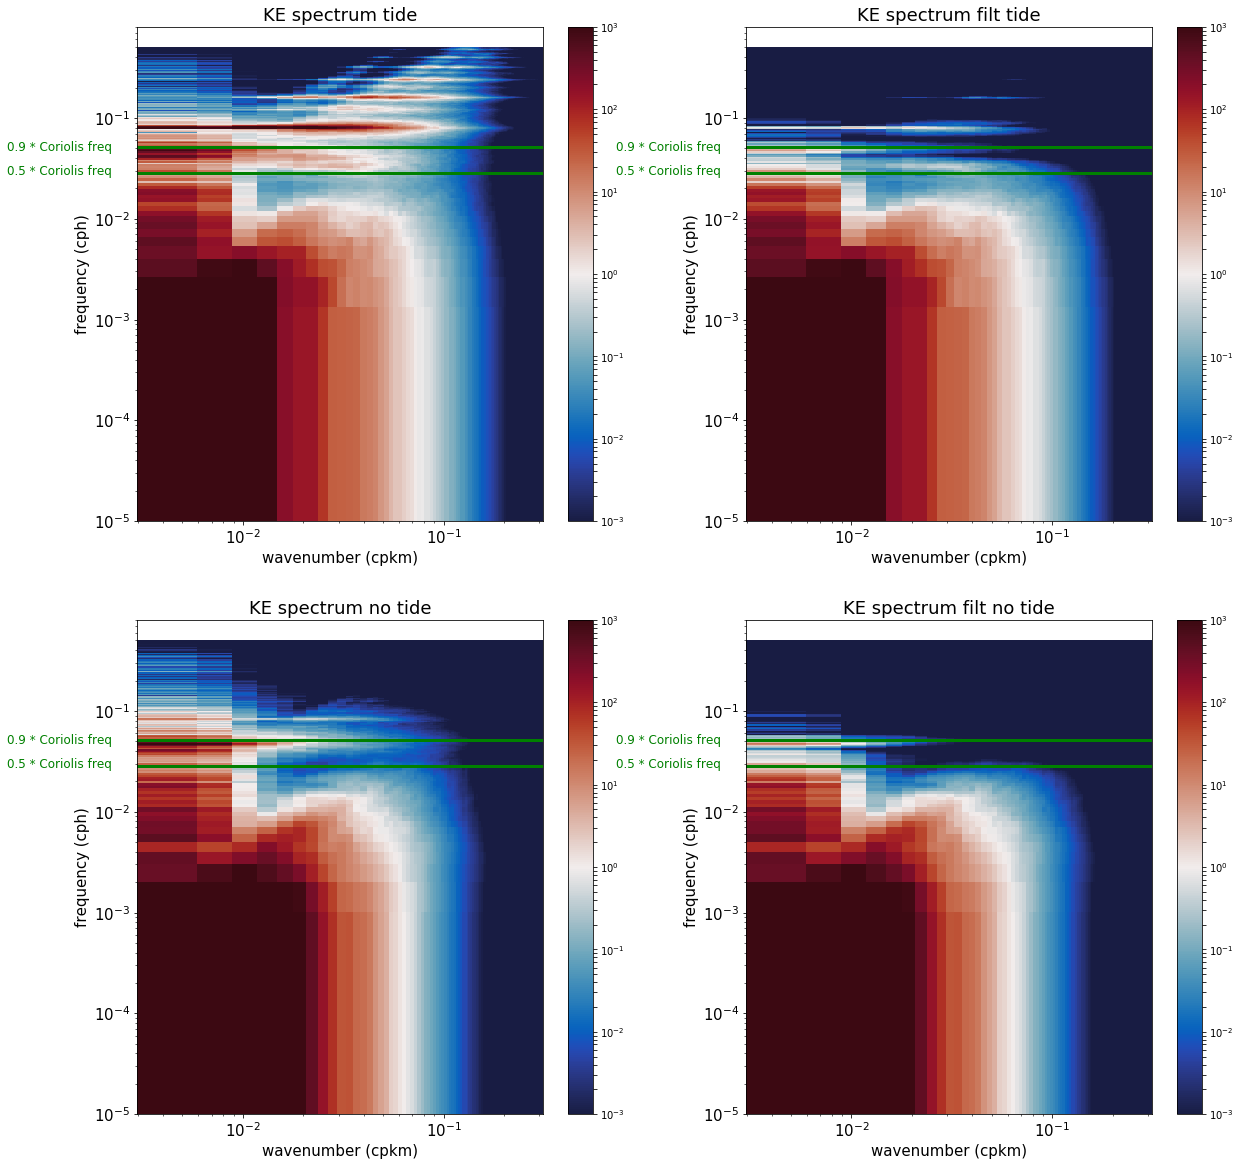

In [27]:
sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = cmocean.cm.balance

fig=plt.figure(figsize=(20,20))

ax = plt.subplot(221)
plt.pcolormesh(Utide_wavenumber,sec_to_hour*Utide_frequency,KEtide_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Utide_wavenumber.min(),Utide_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
plt.axhline(y=0.9/T,color='g', linewidth=3)
plt.axhline(y=0.5/T,color='g', linewidth=3)
ax.set_title('KE spectrum tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()
ax.text(-0.32, 0.75, "0.9 * Coriolis freq", transform=ax.transAxes,color='g',size=12)
ax.text(-0.32, 0.7, "0.5 * Coriolis freq", transform=ax.transAxes,color='g',size=12)

ax = plt.subplot(222)
plt.pcolormesh(Utidefilt_wavenumber,sec_to_hour*Utide_frequency,KEtidefilt_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Utidefilt_wavenumber.min(),Utidefilt_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
ax.axhline(y=0.9/T,color='g',linewidth=3)
ax.axhline(y=0.5/T,color='g',linewidth=3)
ax.set_title('KE spectrum filt tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()
ax.text(-0.32, 0.75, "0.9 * Coriolis freq", transform=ax.transAxes,color='g',size=12)
ax.text(-0.32, 0.7, "0.5 * Coriolis freq", transform=ax.transAxes,color='g',size=12)

ax = plt.subplot(223)
plt.pcolormesh(Unotide_wavenumber,sec_to_hour*Unotide_frequency,KEnotide_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Unotide_wavenumber.min(),Unotide_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
plt.axhline(y=0.9/T,color='g', linewidth=3)
plt.axhline(y=0.5/T,color='g', linewidth=3)
ax.set_title('KE spectrum no tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()
ax.text(-0.32, 0.75, "0.9 * Coriolis freq", transform=ax.transAxes,color='g',size=12)
ax.text(-0.32, 0.7, "0.5 * Coriolis freq", transform=ax.transAxes,color='g',size=12)

ax = plt.subplot(224)
plt.pcolormesh(Unotidefilt_wavenumber,sec_to_hour*Unotide_frequency,KEnotidefilt_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(Unotidefilt_wavenumber.min(),Unotidefilt_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
ax.axhline(y=0.9/T,color='g',linewidth=3)
ax.axhline(y=0.5/T,color='g',linewidth=3)
ax.set_title('KE spectrum filt no tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()
ax.text(-0.32, 0.75, "0.9 * Coriolis freq", transform=ax.transAxes,color='g',size=12)
ax.text(-0.32, 0.7, "0.5 * Coriolis freq", transform=ax.transAxes,color='g',size=12)

plt.savefig("freq-wavenumb-diag-tide-notide-filt-nofilt.png")